# Определение перспективного тарифа для телеком компании



В проекте проанализированы два тарифных плана оператора сотовой связи и выявлено какой тариф приносит больше денег.

Рассмотрены 5 датасетов: данные по использованию звонков, интернета, сообщений, данные по тарифам и пользователям.

***В проекте проанализировано:*** поведение клиентов оператора, исходя из выборки, сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Рассчитано: помесячная выручка с каждого пользователя, среднее количество, дисперсия и стандартное отклонение, построены гистограммы и описаны распределения.
Проверены гипотезы: о средней выручке пользователей по тарифам,  о средней выручке пользователей из Москвы и из других регионов.

**В результате анализа тарифов и пользователей определен выгодный тариф для сотового оператора, приведены конкретные показатели в сравнении с другим тарифом, проанализировано поведение клиентов, проверены гипотезы.**



## Изучение данных из файла

### Изучение данных из файла tariffs

In [1]:
import pandas as pd
from IPython.display import display
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns


data_tariffs = pd.read_csv('/datasets/tariffs.csv')
display(data_tariffs.head())


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<div class="alert alert-info">
<b> </b>

1. Для удобства переведем мегабайты в гигабайты, чтобы вести все дальнейшие расчеты в ГБ, т.к. сверх тарифа идет ст-ть ГБ.
    
2. Поменяем название столбца 'rub_monthly_fee' на 'price_month' для удобного чтения и порядок столбцов для наглядности.

    
</div>

In [2]:
data_tariffs['gb_included']=(data_tariffs['mb_per_month_included']/1024).astype('int64')
data_tariffs = data_tariffs.rename(columns={'rub_monthly_fee': 'price_month'})
data_tariffs=data_tariffs[['tariff_name', 'messages_included', 'gb_included', 'minutes_included', 'price_month', 'rub_per_gb', 'rub_per_message', 'rub_per_minute']]
display(data_tariffs.head())


,tariff_name,messages_included,gb_included,minutes_included,price_month,rub_per_gb,rub_per_message,rub_per_minute
0,smart,50,15,500,550,200,3,3
1,ultra,1000,30,3000,1950,150,1,1


### Изучение данных из файла data_calls

In [3]:
data_calls = pd.read_csv('/datasets/calls.csv')
display(data_calls.head())
data_calls.info()
data_calls.describe()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [4]:
data_calls.query('duration == 0')['duration'].count()

39613

<div class="alert alert-info">
<b> </b>

1. Есть звонки продолжительностью 0 минут, это, скорее всего, неотвеченные
    
2. Не будем их убирать, они никак не повлияют.

3. Пропущенных значений нет.
    
4. Надо перевести время в формат даты, чтобы потом разделить по месяцам.
    
5. Время звонка округлить до целого в большую сторону.
    
6. Добавим столбец с месяцем.
    
7. Переведем время в int.
    
8. Оставим только нужные столбцы - идентиф.пользователя, месяц и время звонка.
    
9. Сгруппируем полученную таблицу по id пользователя и месяца.    
</div>

### Предобработка данных data_calls

In [5]:
data_calls = data_calls.drop_duplicates() # удалим дубликаты в таблице
data_calls.info() # проверим кол-во оставшихся строк

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 7.7+ MB


In [6]:
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')
data_calls['month'] = data_calls['call_date'].dt.month #добавим месяц
import math
import numpy
data_calls['duration'] = numpy.ceil(data_calls['duration']).astype('Int64') #округляем до целого в большую сторону

In [7]:
display(data_calls.head())
data_calls.info()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


<class 'pandas.core.frame.DataFrame'>
Int64Index: 202607 entries, 0 to 202606
Data columns (total 5 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null Int64
user_id      202607 non-null int64
month        202607 non-null int64
dtypes: Int64(1), datetime64[ns](1), int64(2), object(1)
memory usage: 9.5+ MB


In [8]:
data_calls=data_calls[['user_id', 'month', 'duration']]
data_calls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202607 entries, 0 to 202606
Data columns (total 3 columns):
user_id     202607 non-null int64
month       202607 non-null int64
duration    202607 non-null Int64
dtypes: Int64(1), int64(2)
memory usage: 6.4 MB


In [9]:
data_calls_pivot = data_calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc='sum').reset_index()     
data_calls_pivot = data_calls_pivot.rename(columns={'duration': 'sum_minut'})
display(data_calls_pivot.head())
data_calls_pivot.info()


,user_id,month,sum_minut
0,1000,5,159
1,1000,6,172
2,1000,7,340
3,1000,8,408
4,1000,9,466


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3174 entries, 0 to 3173
Data columns (total 3 columns):
user_id      3174 non-null int64
month        3174 non-null int64
sum_minut    3174 non-null Int64
dtypes: Int64(1), int64(2)
memory usage: 77.6 KB


<div class="alert alert-info">
<b> </b>

1. Данные по звонкам преобразованы
    
2. Таблица содержит идентиф.пользователя, месяц и сумму минут за месяц.

3. Строки сократились до 3174.
    
 
</div>

### Изучение данных из файла messages

In [10]:
data_messages = pd.read_csv('/datasets/messages.csv')
display(data_messages.head())
data_messages.info()


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


<div class="alert alert-info">
<b> </b>

1. Пропущенных значений нет.
    
2. Надо перевести время в формат даты, чтобы потом разделить по месяцам.
  
3. Добавим столбец с месяцем.
    
4. Сгруппируем полученную таблицу по id пользователя и месяцам.    
</div>

### Предобработка данных messages

In [11]:
data_messages = data_messages.drop_duplicates() # удалим дубликаты в таблице
data_messages.info() # проверим кол-во оставшихся строк


<class 'pandas.core.frame.DataFrame'>
Int64Index: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 3.8+ MB


In [12]:
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')
data_messages['month'] = data_messages['message_date'].dt.month #добавим месяц
display(data_messages.head())
data_messages.info()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


<class 'pandas.core.frame.DataFrame'>
Int64Index: 123036 entries, 0 to 123035
Data columns (total 4 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
month           123036 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.7+ MB


In [13]:
data_messages_pivot = data_messages.pivot_table(index=['user_id', 'month'], values='message_date', aggfunc='count').reset_index()     
display(data_messages_pivot.head())
data_messages_pivot.info()


,user_id,month,message_date
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 3 columns):
user_id         2717 non-null int64
month           2717 non-null int64
message_date    2717 non-null int64
dtypes: int64(3)
memory usage: 63.8 KB


In [14]:
data_messages_pivot = data_messages_pivot.rename(columns={'message_date': 'sum_message'}) #поменяем название для удобства
#чтобы название соответствовало содержимому
data_messages_pivot.head()

,user_id,month,sum_message
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


<div class="alert alert-info">
<b> </b>

1. Данные по кол-ву сообщений преобразованы
    
2. Таблица содержит идентиф.пользователя, месяц и кол-во сообщений за месяц по каждому абоненту.

3. Строки сократились до 2717.
    
 
</div>

### Изучение данных из файла internet

In [15]:
data_internet = pd.read_csv('/datasets/internet.csv')
display(data_internet.head())
data_internet.info()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


<div class="alert alert-info">
<b> </b>

1. Пропущенных значений нет.
    
2. Надо перевести время в формат даты, чтобы потом разделить по месяцам.
  
3. Добавим столбец с месяцем.
    
4. Интернет переведем в ГБ, т.к. перерасход начисляется за гигабайты и преобразуем в int с округлением в большую сторону.
    
5. Сгруппируем полученную таблицу по id пользователя и месяцам.    
</div>

### Предобработка данных internet

In [16]:
data_internet = data_internet.drop_duplicates() # удалим дубликаты в таблице
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')
data_internet['month'] = data_internet['session_date'].dt.month #добавим месяц

data_internet['gb_used']=data_internet['mb_used'] / 1024

data_internet['gb_used'] = numpy.ceil(data_internet['gb_used']).astype('Int64')

data_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id,month,gb_used
0,0,1000_0,112.95,2018-11-25,1000,11,1
1,1,1000_1,1052.81,2018-09-07,1000,9,2
2,2,1000_2,1197.26,2018-06-25,1000,6,2
3,3,1000_3,550.27,2018-08-22,1000,8,1
4,4,1000_4,302.56,2018-09-24,1000,9,1


In [17]:
data_internet=data_internet[['user_id', 'month', 'gb_used']]
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 3 columns):
user_id    149396 non-null int64
month      149396 non-null int64
gb_used    149396 non-null Int64
dtypes: Int64(1), int64(2)
memory usage: 4.7 MB


In [18]:
data_internet_pivot = data_internet.pivot_table(index=['user_id', 'month'], values='gb_used', aggfunc='sum').reset_index()     
display(data_internet_pivot.head())
data_internet_pivot.info()

,user_id,month,gb_used
0,1000,5,4
1,1000,6,49
2,1000,7,28
3,1000,8,27
4,1000,9,26


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3203 entries, 0 to 3202
Data columns (total 3 columns):
user_id    3203 non-null int64
month      3203 non-null int64
gb_used    3203 non-null Int64
dtypes: Int64(1), int64(2)
memory usage: 78.3 KB


In [19]:
data_internet_pivot = data_internet_pivot.rename(columns={'gb_used': 'sum_gb'}) #поменяем название, 
#чтобы соответствовало содержанию
data_internet_pivot.head()

,user_id,month,sum_gb
0,1000,5,4
1,1000,6,49
2,1000,7,28
3,1000,8,27
4,1000,9,26


<div class="alert alert-info">
<b> </b>

1. Данные по кол-ву ГБ преобразованы
    
2. Таблица содержит идентиф.пользователя, месяц и кол-во ГБ за месяц по каждому абоненту.

3. Строки сократились до 3203.
    
 
</div>

### Изучение данных из файла users

In [20]:
data_users = pd.read_csv('/datasets/users.csv')
display(data_users.head())
data_users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


<div class="alert alert-info">
<b> </b>

1. Есть пропущенные значения в дате прекращения тарифа, т.к. большинство тарифов еще действовало.
    
2. Оставляем только нужные для анализа столбцы - идентиф.абонента, тариф и город.

   
</div>

### Предобработка данных users

In [21]:
data_users=data_users[['user_id', 'tariff', 'city']]
data_users = data_users.drop_duplicates() # удалим дубликаты в таблице

display(data_users.head())
data_users.info()

,user_id,tariff,city
0,1000,ultra,Краснодар
1,1001,smart,Москва
2,1002,smart,Стерлитамак
3,1003,ultra,Москва
4,1004,ultra,Новокузнецк


<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
user_id    500 non-null int64
tariff     500 non-null object
city       500 non-null object
dtypes: int64(1), object(2)
memory usage: 15.6+ KB


## Объединение таблиц

<div class="alert alert-info">
<b> Объединим таблицы звонков и сообщений </b>
  
</div>

In [22]:
data=data_calls_pivot.merge(data_messages_pivot, on=['user_id', 'month'], how='outer')
display(data.head())
data.info()


,user_id,month,sum_minut,sum_message
0,1000,5,159,22.0
1,1000,6,172,60.0
2,1000,7,340,75.0
3,1000,8,408,81.0
4,1000,9,466,57.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3213 entries, 0 to 3212
Data columns (total 4 columns):
user_id        3213 non-null int64
month          3213 non-null int64
sum_minut      3174 non-null Int64
sum_message    2717 non-null float64
dtypes: Int64(1), float64(1), int64(2)
memory usage: 128.6 KB


<div class="alert alert-info">
<b> Объединим полученную таблицу с таблицей интернета </b>
  
</div>

In [23]:
data=data.merge(data_internet_pivot, on=['user_id', 'month'], how='outer')
display(data.head())
data.info()

,user_id,month,sum_minut,sum_message,sum_gb
0,1000,5,159,22.0,4
1,1000,6,172,60.0,49
2,1000,7,340,75.0,28
3,1000,8,408,81.0,27
4,1000,9,466,57.0,26


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 5 columns):
user_id        3214 non-null int64
month          3214 non-null int64
sum_minut      3174 non-null Int64
sum_message    2717 non-null float64
sum_gb         3203 non-null Int64
dtypes: Int64(2), float64(1), int64(2)
memory usage: 156.9 KB


<div class="alert alert-info">
<b> Объединим полученную таблицу с таблицей абонентов </b>
  
</div>

In [24]:
data=data.merge(data_users, on=['user_id'], how='outer')
display(data.head())
data.info()

,user_id,month,sum_minut,sum_message,sum_gb,tariff,city
0,1000,5.0,159,22.0,4,ultra,Краснодар
1,1000,6.0,172,60.0,49,ultra,Краснодар
2,1000,7.0,340,75.0,28,ultra,Краснодар
3,1000,8.0,408,81.0,27,ultra,Краснодар
4,1000,9.0,466,57.0,26,ultra,Краснодар


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 7 columns):
user_id        3216 non-null int64
month          3214 non-null float64
sum_minut      3174 non-null Int64
sum_message    2717 non-null float64
sum_gb         3203 non-null Int64
tariff         3216 non-null object
city           3216 non-null object
dtypes: Int64(2), float64(2), int64(1), object(2)
memory usage: 207.3+ KB


<div class="alert alert-info">
<b> В итоговой таблице есть попущенные значения и float </b>

- Заменим отсутствующие значения на 0 и переведем количественные столбцы в int  
</div>

In [25]:
data = data.fillna(
    {
        'sum_message':0,
        'sum_minut':0,
        'sum_gb':0,
        'month':0,
        }
)

data = data.astype(
    {
        'sum_message':'int',
        'sum_minut':'int',
        'sum_gb':'int',
        'month':'int',
        }
)
data=data.query('month > 0')

In [26]:
display(data.head())
data.info()

,user_id,month,sum_minut,sum_message,sum_gb,tariff,city
0,1000,5,159,22,4,ultra,Краснодар
1,1000,6,172,60,49,ultra,Краснодар
2,1000,7,340,75,28,ultra,Краснодар
3,1000,8,408,81,27,ultra,Краснодар
4,1000,9,466,57,26,ultra,Краснодар


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 7 columns):
user_id        3214 non-null int64
month          3214 non-null int64
sum_minut      3214 non-null int64
sum_message    3214 non-null int64
sum_gb         3214 non-null int64
tariff         3214 non-null object
city           3214 non-null object
dtypes: int64(5), object(2)
memory usage: 200.9+ KB


<div class="alert alert-info">
<b> Итоговая таблица преобразована </b>

- В ней содержится вся информация по минутам, сообщениям и гигабайтам, по каждому абоненту ежемесячно.
</div>

## Помесячная выручка с каждого пользователя

In [27]:
data_tariffs.head() #вспомним условия каждого тарифа

,tariff_name,messages_included,gb_included,minutes_included,price_month,rub_per_gb,rub_per_message,rub_per_minute
0,smart,50,15,500,550,200,3,3
1,ultra,1000,30,3000,1950,150,1,1


In [28]:
def price(df):
    sum_minut = df['sum_minut']
    sum_message = df['sum_message']
    sum_gb = df['sum_gb']
    tariff = df['tariff']
    if tariff == 'smart':
        if sum_minut > 500:
            price_min=(sum_minut-500)*3 #стоимость минут потраченных сверх тарифа
        else:
            price_min = 0
        if sum_message > 50:
            price_message=(sum_message-50)*3 #стоимость сообщений потраченных сверх тарифа
        else:
            price_message = 0
        if sum_gb > 15:
            price_gb=(sum_gb-15)*200 #стоимость гб потраченных сверх тарифа
        else:
            price_gb = 0
        return price_min + price_message + price_gb + 550 #цена за месяц: тариф + потраченное сверху
    elif tariff == 'ultra':
        if sum_minut > 3000:
            price_min=sum_minut-3000 #стоимость минут потраченных сверх тарифа
        else:
            price_min = 0
        if sum_message > 1000:
            price_message=sum_message-1000 #стоимость сообщений потраченных сверх тарифа
        else:
            price_message = 0
        if sum_gb > 30:
            price_gb=(sum_gb-30)*150 #стоимость гб потраченных сверх тарифа
        else:
            price_gb = 0
        return price_min + price_message + price_gb + 1950 #цена за месяц: тариф + потраченное сверху
            
  
   
data['price_month'] =  data.apply(price, axis=1) #новый столбец, функцию ко всей строке

In [29]:
display(data.head()) #проверим результат
data.info()

,user_id,month,sum_minut,sum_message,sum_gb,tariff,city,price_month
0,1000,5,159,22,4,ultra,Краснодар,1950
1,1000,6,172,60,49,ultra,Краснодар,4800
2,1000,7,340,75,28,ultra,Краснодар,1950
3,1000,8,408,81,27,ultra,Краснодар,1950
4,1000,9,466,57,26,ultra,Краснодар,1950


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 8 columns):
user_id        3214 non-null int64
month          3214 non-null int64
sum_minut      3214 non-null int64
sum_message    3214 non-null int64
sum_gb         3214 non-null int64
tariff         3214 non-null object
city           3214 non-null object
price_month    3214 non-null int64
dtypes: int64(6), object(2)
memory usage: 226.0+ KB


<div class="alert alert-info">
<b> Таблица готова к анализу </b>


</div>

## Анализ результатов


In [30]:
data_tariffs.head() #вспоминаем условия тарифов, чтобы сравнить с показателями describe

,tariff_name,messages_included,gb_included,minutes_included,price_month,rub_per_gb,rub_per_message,rub_per_minute
0,smart,50,15,500,550,200,3,3
1,ultra,1000,30,3000,1950,150,1,1


### Анализ тарифа ULTRA

In [31]:
data_ultra=data.query('tariff == "ultra"')
data_ultra.describe()


,user_id,month,sum_minut,sum_message,sum_gb,price_month
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,1263.094416,8.250761,526.623350,49.363452,38.164467,3844.416244
std,140.694908,2.871762,317.606098,47.804457,19.564656,2166.139153
min,1000.000000,1.000000,0.000000,0.000000,0.000000,1950.000000
25%,1143.000000,6.000000,284.000000,6.000000,23.000000,1950.000000
50%,1277.000000,9.000000,518.000000,38.000000,38.000000,3150.000000
75%,1381.000000,11.000000,752.000000,79.000000,52.000000,5250.000000
max,1495.000000,12.000000,1673.000000,224.000000,98.000000,12150.000000


In [32]:
user_ultra_30 = data_ultra.query('sum_gb>30')['sum_gb'].count()
user_ultra_30 

623

In [33]:
user_ultra_30 / 985

0.63248730964467

<div class="alert alert-info">
<b> В тариф УЛЬТРА входит 1000 сообщений, 30 гб, 3000 минут, абонет.плата - 1950р. </b>

- Максимальное кол-во  в месяц сообщений было 224, минут 1673, что не превышает лимит.
    
- А максимальное кол-во гб в месяц было 98, причем более 50% от всех месяцев лимит превышался.
    
- Только 25% абонентов укладываются в лимит, остальные платят больше за счет интернета.
    
- Средний ежемесячный чек - 3844р., что почти в 2 раза больше абоненской платы.
    
- 63% наблюдений превышает лимит интернета в 30 ГБ   
</div>

In [34]:
data_ultra.head()

,user_id,month,sum_minut,sum_message,sum_gb,tariff,city,price_month
0,1000,5,159,22,4,ultra,Краснодар,1950
1,1000,6,172,60,49,ultra,Краснодар,4800
2,1000,7,340,75,28,ultra,Краснодар,1950
3,1000,8,408,81,27,ultra,Краснодар,1950
4,1000,9,466,57,26,ultra,Краснодар,1950


#### Анализ ULTRA - минуты

In [35]:
import numpy as np
variance = np.var(data_ultra['sum_minut'], ddof=1)
print('Дисперсия - ', variance)
print('Отклонение - ', np.sqrt(variance))
print('Среднее - ', data_ultra['sum_minut'].mean())

Дисперсия -  100873.63339730098
Отклонение -  317.6060978591264
Среднее -  526.6233502538071


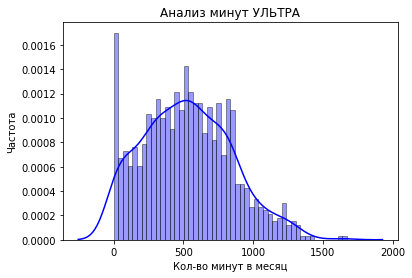

In [36]:
import seaborn as sns
sns.distplot(data_ultra['sum_minut'], hist=True, 
             bins=50, color = 'blue', hist_kws={'edgecolor':'black'}).set_title('Анализ минут УЛЬТРА')

plt.xlabel("Кол-во минут в месяц") # подпись к оси X
plt.ylabel("Частота"); # подпись к оси Y

<div class="alert alert-info">
<b> Распределение скошено влево, распределение мультимодальное </b>

- Половина абонентов используют до 500 минут в месяц из возможных 3000 минут и 
    25% абонентов пользуются только 9% минут от лимита.
- Часть пользователей минимально пользуются минутами, другие приложения с помощью интернета заменяют связь.
</div>

#### Анализ ULTRA - сообщения

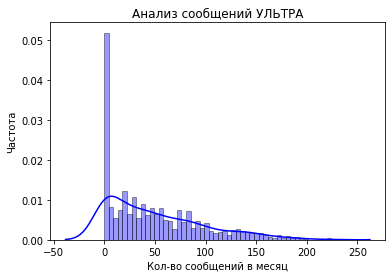

In [37]:
import seaborn as sns
sns.distplot(data_ultra['sum_message'], hist=True, 
             bins=50, color = 'blue', hist_kws={'edgecolor':'black'}).set_title('Анализ сообщений УЛЬТРА')

plt.xlabel("Кол-во сообщений в месяц") # подпись к оси X
plt.ylabel("Частота"); # подпись к оси Y

In [38]:
variance = np.var(data_ultra['sum_message'], ddof=1)
print('Дисперсия - ', variance)
print('Отклонение - ', np.sqrt(variance))
print('Среднее - ', data_ultra['sum_message'].mean())

Дисперсия -  2285.2661425446736
Отклонение -  47.804457350174715
Среднее -  49.36345177664975


<div class="alert alert-info">
<b> По тарифу УЛЬТРА лимит сообщений в месяц - 1000 </b>
    
- Распределение скошено влево, 50% абонентов используют в месяц до 38 сообщений, что около 4% от лимита.
- 25% абонентов отправляют до 6 сообщений в месяц, что меньше 1% от лимита, на графике это выглядит как выброс.
- обычные сообщения часто заменяются телеграмом, ватсапом и др, т.е. посредством интернета.
- сообщения меньше всего интересуют клиентов.
    
</div>

#### Анализ ULTRA - интернет

In [39]:
variance = np.var(data_ultra['sum_gb'], ddof=1)
print('Дисперсия - ', variance)
print('Отклонение - ', np.sqrt(variance))
print('Среднее - ', data_ultra['sum_gb'].mean())

Дисперсия -  382.7757686434732
Отклонение -  19.564656108489952
Среднее -  38.16446700507614


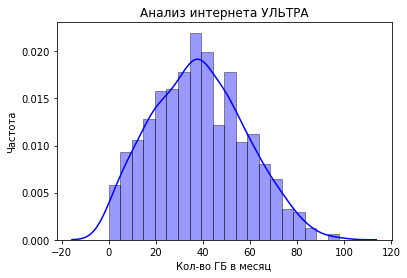

In [40]:
sns.distplot(data_ultra['sum_gb'], hist=True, 
             bins=20, color = 'blue', hist_kws={'edgecolor':'black'}).set_title('Анализ интернета УЛЬТРА')

plt.xlabel("Кол-во ГБ в месяц") # подпись к оси X
plt.ylabel("Частота"); # подпись к оси Y


<div class="alert alert-info">
<b> По тарифу УЛЬТРА лимит интернета - 30 гб </b>
    
- Распределение нормальное, т.к. интернетом пользуются полноценно, звонки и сообщения часто через приложения и соответственно при помощи интернета.
- Лимит интернета является почти средним в этом распределении.    
- 30 гб чуть ниже среднего, больше половины абонентов превышают лимит, очень выгодная ситуация для сотового оператора.

    
</div>

In [41]:
gb_ultra=(1-1950*(data_ultra['month'].count()) / data_ultra['price_month'].sum())*100
gb_ultra

49.277084571202224

<div class="alert alert-info">
<b>49% от выручки по тарифу УЛЬТРА составляет дополнительный интернет </b>
    
- минуты входят в стоимость, никто из абонентов не тратит доп.минуты,
- сообщения входят в стоимость, никто из абонентов не тратит доп.сообщения,
- половину выручки по тарифу составляет дополнительный интернет.

    
</div>

### Анализ тарифа SMART

In [42]:
data_tariffs

,tariff_name,messages_included,gb_included,minutes_included,price_month,rub_per_gb,rub_per_message,rub_per_minute
0,smart,50,15,500,550,200,3,3
1,ultra,1000,30,3000,1950,150,1,1


In [43]:
data_smart=data.query('tariff == "smart"')
data_smart.describe()

,user_id,month,sum_minut,sum_message,sum_gb,price_month
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000
mean,1246.506505,8.346792,417.934948,33.384029,42.418125,6247.084343
std,146.119496,2.920316,190.313730,28.227876,14.943104,2893.717526
min,1001.000000,1.000000,0.000000,0.000000,0.000000,550.000000
25%,1121.000000,6.000000,282.000000,10.000000,34.000000,4503.000000
50%,1239.000000,9.000000,422.000000,28.000000,43.000000,6350.000000
75%,1376.000000,11.000000,545.000000,51.000000,52.000000,8065.000000
max,1499.000000,12.000000,1435.000000,143.000000,101.000000,19370.000000


In [44]:
user_smart_15 = data_smart.query('sum_gb>15')['sum_gb'].count()
user_smart_15

2113

<div class="alert alert-info">
<b> 2113 раз был превышен лимит 15 ГБ </b>

    
</div>

In [45]:
user_smart_15/2229


0.9479587258860476

<div class="alert alert-info">
<b> в 95% наблюдений был превышен лимит 15 ГБ </b>

    
</div>

In [46]:
user_smart_30 = data_smart.query('sum_gb>30')['sum_gb'].count()
user_smart_30

1803

<div class="alert alert-info">
<b> 1803 раз был превышен лимит 30 ГБ </b>

    
</div>

In [47]:
user_smart_30/2229

0.8088829071332436

<div class="alert alert-info">
<b> в 81% наблюдений был превышен лимит 30 ГБ </b>

    
</div>

<div class="alert alert-info">
<b> В тариф СМАРТ входит 50 сообщений, 15 ГБ, 500 минут, абонент плата - 550 руб. </b>
    
- 25% абонентов используют доп.сообщения,
- Больше 75% абонентов используют дополнительный интернет,
- Средний показатель ежемес.объема интернета почти в 3 раза превышает лимит.
- Более 25% абонентов используют дополнительные минуты.
- Средний ежемесячный чек в 11 раз превышает абонентскую плату.
- 94% наблюдений - больше 15 ГБ, т.е. вышли за лимит
- 81% - больше 30 ГБ, это необходимо для сравнения с поведением абонементов УЛЬТРА
    
</div>

#### Анализ SMART минуты

In [48]:
variance = np.var(data_smart['sum_minut'], ddof=1)
print('Дисперсия - ', variance)
print('Отклонение - ', np.sqrt(variance))
print('Среднее - ', data_smart['sum_minut'].mean())

Дисперсия -  36219.31578434428
Отклонение -  190.31372988921288
Среднее -  417.9349484073576


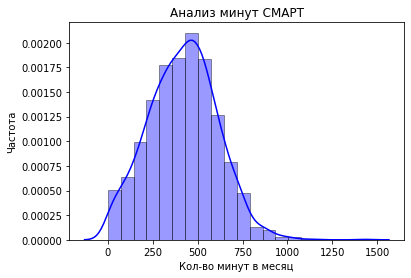

In [49]:
sns.distplot(data_smart['sum_minut'], hist=True, 
             bins=20, color = 'blue',
             hist_kws={'edgecolor':'black'}).set_title('Анализ минут СМАРТ')

plt.xlabel("Кол-во минут в месяц") # подпись к оси X
plt.ylabel("Частота"); # подпись к оси Y



<div class="alert alert-info">
<b>Распределение нормальное </b>

- Среднее кол-во минут стремится к ежемесячному лимиту и при этом среднее отклонение составляет 35% от лимита
- Абоненты не укладываются в лимит, и оплачивают доп.минуты.    
   
</div>

<div class="alert alert-info">
<b>Посчитаем % отношение выручки от доп.минут к общей выручке </b>
    
   
</div>

In [50]:
min_smart=data_smart.query('sum_minut > 500')['sum_minut'].sum() - data_smart.query('sum_minut > 500')['sum_minut'].count() * 500
print(min_smart) #кол-во дополнительных минут
((min_smart*3)/data_smart['price_month'].sum())*100

92739


1.9980034113356855

<div class="alert alert-info">
<b>Выручка от доп.минут составляет 2% ко всей выручке по тарифу</b>
    
   
</div>

<div class="alert alert-info">
<b>Посчитаем % отношение выручки от доп.минут к выручке по абон.плате (2229 абонетов по 550 руб.) </b>
    
   
</div>

In [51]:
min_smart=data_smart.query('sum_minut > 500')['sum_minut'].sum() - data_smart.query('sum_minut > 500')['sum_minut'].count() * 500
print(min_smart) #кол-во дополнительных минут
(min_smart*3)/(2229*550)

92739


0.2269399241404625

<div class="alert alert-info">
<b>Выручка от доп.минут составляет 22,3% к абоненской плате</b>
    
   
</div>

#### Анализ SMART сообщения

In [52]:
variance = np.var(data_smart['sum_message'], ddof=1)
print('Дисперсия - ', variance)
print('Отклонение - ', np.sqrt(variance))
print('Среднее - ', data_smart['sum_message'].mean())

Дисперсия -  796.8129584480083
Отклонение -  28.22787555676141
Среднее -  33.384028712427096


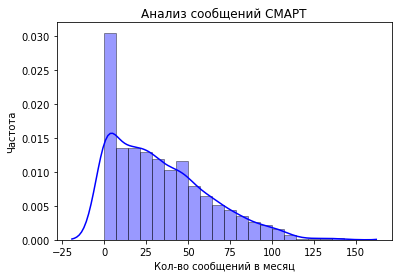

In [53]:
sns.distplot(data_smart['sum_message'], hist=True, 
             bins=20, color = 'blue',
             hist_kws={'edgecolor':'black'}).set_title('Анализ сообщений СМАРТ')

plt.xlabel("Кол-во сообщений в месяц") # подпись к оси X
plt.ylabel("Частота"); # подпись к оси Y



<div class="alert alert-info">
<b> Распределение скошено влево </b>

- 25% от всех месяцев использовали менее 10 сообщений, при наличии интернета сообщения становятся менее востребованными.
- 75% - укладывались в лимит 50 сообщений
- и только 25% пользовались доп.сообщениями.
- Среднее немного больше среднего по лимиту (т.е. 25 сообщений из 50) 
- И с учетом отклонения 28, большая часть наблюдений укладывается в лимит.
    
   
</div>

In [54]:
mess_smart=data_smart.query('sum_message > 50')['sum_message'].sum() - data_smart.query('sum_message > 50')['sum_message'].count() * 50
print(mess_smart) #кол-во дополнительных сообщений
(mess_smart*3)/(2229*550)

12928


0.03163587421999266

<div class="alert alert-info">
<b>Выручка от доп.сообщений составляет 3% к абонентской плате </b>
    
   
</div>

In [55]:
mess_smart=data_smart.query('sum_message > 50')['sum_message'].sum() - data_smart.query('sum_message > 50')['sum_message'].count() * 50
print(mess_smart) #кол-во дополнительных сообщений
((mess_smart*3)/data_smart['price_month'].sum())*100

12928


0.27852562677781456

<div class="alert alert-info">
<b>Выручка от доп.сообщений составляет 0,3% ко всей выручке по тарифу</b>
    
   
</div>

#### Анализ SMART интернет

In [56]:
variance = np.var(data_smart['sum_gb'], ddof=1)
print('Дисперсия - ', variance)
print('Отклонение - ', np.sqrt(variance))
print('Среднее - ', data_smart['sum_gb'].mean())

Дисперсия -  223.2963679359641
Отклонение -  14.943104360739909
Среднее -  42.4181247196052


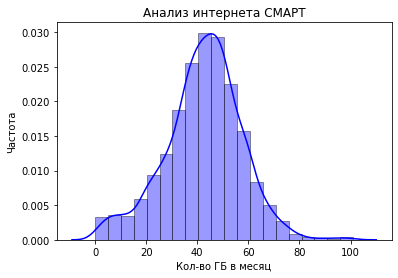

In [57]:
sns.distplot(data_smart['sum_gb'], hist=True, 
             bins=20, color = 'blue',
             hist_kws={'edgecolor':'black'}).set_title('Анализ интернета СМАРТ')

plt.xlabel("Кол-во ГБ в месяц") # подпись к оси X
plt.ylabel("Частота"); # подпись к оси Y


<div class="alert alert-info">
<b>Распределение нормальное</b>

- 15 гб входящих в лимит ниже среднего, менее 25% наблюдений укладываются в лимит, это очень выгодная ситуация для сотового оператора. 
- Чем ниже среднего лимит, тем больше прибыли. 
    
</div>

In [58]:
gb_smart=data_smart.query('sum_gb > 15')['sum_gb'].sum() - data_smart.query('sum_gb > 15')['sum_gb'].count() * 15
print(gb_smart) #кол-во дополнительных gb
((gb_smart*200)/data_smart['price_month'].sum())*100

61909


88.91936380047298

<div class="alert alert-info">
<b>Выручка от доп.gb интернета составляет 89% ко всей выручке по тарифу</b>
    
   
</div>

In [59]:
gb_smart=data_smart.query('sum_gb > 15')['sum_gb'].sum() - data_smart.query('sum_gb > 15')['sum_gb'].count() * 15
print(gb_smart) #кол-во дополнительных gb
(gb_smart*200)/(2229*550)

61909


10.09975937028427

<div class="alert alert-info">
<b>Выручка от доп.gb интернета в 10 раз!!! больше выручки от тарифа по лимиту (2229 мес* 550 руб/мес) </b>
    
   
</div>

## Проверка гипотез

### Средняя выручка Ультра и Смарт

<div class="alert alert-info">
<b>Средняя выручка по тарифам Ультра и Смарт равны 3844 руб. и 6247 руб.  </b>

- Предположим что это могло произойти случайно.
    
- Пусть нулевая гипотеза звучит так - средние выручки равны
    
- Альтернативная  - не равны
   
</div>

In [60]:
from scipy import stats as st
import numpy as np

alpha = 0.05

results = st.ttest_ind(data_ultra['price_month'], data_smart['price_month'], equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 


p-значение: 3.366123216919074e-132
Отвергаем нулевую гипотезу


<div class="alert alert-info">
<b>p-значение очень маленькое - 3 деленное на 10 в 132 степени </b>

- Очень маленькая вероятность того что средние выручки равны.
    
   
</div>

### Средняя выручка Москва и другие города

In [61]:
data.head() #посмотрим какой столбец овечает за город

,user_id,month,sum_minut,sum_message,sum_gb,tariff,city,price_month
0,1000,5,159,22,4,ultra,Краснодар,1950
1,1000,6,172,60,49,ultra,Краснодар,4800
2,1000,7,340,75,28,ultra,Краснодар,1950
3,1000,8,408,81,27,ultra,Краснодар,1950
4,1000,9,466,57,26,ultra,Краснодар,1950


In [62]:
print('Уникальные значения в столбце city')
print(data['city'].value_counts())

Уникальные значения в столбце city
Москва             611
Санкт-Петербург    270
Новосибирск         98
Уфа                 95
Краснодар           86
                  ... 
Сургут               6
Нижневартовск        6
Химки                5
Кемерово             5
Иваново              2
Name: city, Length: 76, dtype: int64


<div class="alert alert-info">
<b>Средняя выручка по Москве и др.городам равны 5397 руб. и 5537 руб.  </b>

- Средние выручки и действительно равны, есть небольшое различие
    
- Пусть нулевая гипотеза звучит так - средние выручки равны
    
- Альтернативная  - не равны
   
</div>

In [63]:
data_msk=data.query('city == "Москва"')
data_msk.describe()

,user_id,month,sum_minut,sum_message,sum_gb,price_month
count,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000
mean,1268.872340,8.432079,469.150573,37.877250,41.623568,5397.040917
std,137.530432,2.888057,241.535044,37.160304,16.111874,2683.243539
min,1001.000000,1.000000,0.000000,0.000000,1.000000,550.000000
25%,1171.000000,6.000000,304.000000,6.500000,31.000000,3300.000000
50%,1291.000000,9.000000,453.000000,29.000000,43.000000,5350.000000
75%,1385.000000,11.000000,620.500000,57.000000,52.500000,7185.500000
max,1490.000000,12.000000,1321.000000,191.000000,94.000000,17121.000000


In [64]:
data_no_msk=data.query('city != "Москва"')
data_no_msk.describe()

,user_id,month,sum_minut,sum_message,sum_gb,price_month
count,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000,2603.000000
mean,1247.533615,8.290434,447.041875,38.376104,40.995006,5537.421821
std,146.011387,2.909368,241.852152,35.913289,16.726412,2961.149677
min,1000.000000,1.000000,0.000000,0.000000,0.000000,550.000000
25%,1120.000000,6.000000,280.500000,9.500000,31.000000,2950.000000
50%,1241.000000,9.000000,440.000000,30.000000,42.000000,5550.000000
75%,1377.000000,11.000000,584.000000,57.000000,51.000000,7558.500000
max,1499.000000,12.000000,1673.000000,224.000000,101.000000,19370.000000


In [65]:
from scipy import stats as st
import numpy as np

alpha = 0.05

results = st.ttest_ind(data_msk['price_month'], data_no_msk['price_month'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 


p-значение: 0.28336464606572015
Не получилось отвергнуть нулевую гипотезу


<div class="alert alert-info">
<b> С вероятностью 28 % небольшое различие можно получить случайно.</b>
 
   
</div>

## Общий вывод

<div class="alert alert-info">
<b>  </b>

**Краткий обзор проведённой работы**
1. Данные со звонками, сообщениями и интернетом, пользователями не содержали пропущенных значений, дубликатов не было.
В таблице звонков была продолжительность 0.0 минут, это неотвеченные звонки , не имеет смысла их убирать, т.к. для анализа суммируем сумму минут за месяц.
    
2. Было проанализировано два тарифа Смарт и Ультра.
    
- В СМАРТ входит  50 сообщений,  500 минут, 15 ГБ, абон.плата – 550 руб.
    
- В УЛЬТРА входит 1000 сообщений,  3000 минут,  30 ГБ, абон.плата – 1950 руб.


**Анализ тарифов сотового оператора**
 
1. Абоненты в обоих тарифах используют интернет значительно больше лимита.
    
- В Ультра в среднем – 38 ГБ, максимально – 98 ГБ.
    
- 63% из всех месяцев  у абонентов УЛЬТРА был превышен лимит ГБ, т.е. было более 30 ГБ

- В Смарте в среднем – 42 ГБ, максимально – 101 ГБ.
    
- 94% из всех месяцев  у абонентов СМАРТ - больше 15 ГБ, т.е. вышли за лимит
    
- 81% из всех месяцев  абоненты СМАРТ использовали более 30 ГБ.

2. Т.е.  в лимиты обоих тарифов входит существенная разница по минутам и сообщениям, а интернет отличатся на 15ГБ.
Фактически абоненты обоих тарифов тратят похожее кол-во минут, сообщений абоненты Ультра тратят в среднем немного больше.
А интернет абоненты Смарта тратят больше и при этом он для них по более дорогой цене. Более 81% месяцев по тарифу Смарт превышают лимит ГБ в два раза, т.е.  за дополнительные 15 ГБ платят 3000. А это значит, что эти 81% - как минимум приносят оператору 3550 рублей при тех же условиях что и тариф УЛЬТРА. Т.е. вместо 1950 получается 3550. А если еще рассмотреть превышение 30 ГБ, то для сотового оператора абоненты Смарта становятся  еще более выгодными, ведь они платят по 200 руб.  за ГБ, а Ультра 150 руб.  за ГБ.

3. Доп.минуты от абонентов Смарт также приносят прибыль сотовому оператору, а именно 22%  от выручке по абон.плате.
Получается что тариф, который дешевле почти в 4 раза выручки приносит больше, 
    
- средняя выручка от абонента в месяц:
    
- УЛЬТРА – 3844 руб.
    
- СМАРТ – 6247 руб.
    
3. **Анализ тарифов и проверка гипотез показывает**, что различие это не случайное, а закономерное.
Поведение пользователей  двух тарифов мало отличается ,  а расценки разные, отсюда и разность в выручке.
Средняя выручка по Москве и другим регионам практически не отличается.


 

**Рекомендации**
 
1. Тариф Смарт приносит больше денег, а значит и корректировать рекламный бюджет надо в его пользу.
2. Сотовому оператору выгоднее подключать абонентов к тарифу Смарт, а так как бОльшую долю выручки приносит доп.интернет,
можно уменьшить абон.плату или добавить в этот тариф минуты и сообщения, для привлечения клиентов.
 




    
</div>